<a href="https://colab.research.google.com/github/rmonro12/Intro_to_ML/blob/main/Homework_Assignments/HW_7/Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ryan Monroe (801219572) - 12/02/2025 <br>
ECGR 4105 - Homework 7, Problem 1

In [ ]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import datetime

In [ ]:
#Check if GPU is available for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


##Feature mapping

In [ ]:
# Define transformations for the images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Download and load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")
print(f"Number of classes: {len(trainset.classes)}")
print(f"Classes: {trainset.classes}")

100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


Training set size: 50000
Test set size: 10000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Assuming a binary classification task is intended,
# where one specific class is considered 'positive' (label 1),
# and all other classes are considered 'negative' (label 0).
# Let's choose 'automobile' (class_id = 1) as the positive class for demonstration.
target_class_id = 1 # 'automobile'

# Function to convert multi-class labels to binary labels
def to_binary_label(labels, target_class_id):
    # Convert labels to 0 for 'not target_class_id' and 1 for 'target_class_id'
    return (labels == target_class_id).long()

# Extract all images and original labels from the training dataset
all_train_images = []
all_train_original_labels = []
for img, label in trainset:
    all_train_images.append(img)
    all_train_original_labels.append(label)

train_X_full = torch.stack(all_train_images)
train_Y_original_full = torch.tensor(all_train_original_labels, dtype=torch.long)

# Convert original labels to binary labels for the training process.
# The training loop expects continuous values for its regression loss,
# so we will use float type for train_Y and val_Y.
train_Y_binary_full = to_binary_label(train_Y_original_full, target_class_id).float()

print(f"Full training data X shape: {train_X_full.shape}, Y original shape: {train_Y_original_full.shape}, Y binary float shape: {train_Y_binary_full.shape}")

# Split the full training data into training and validation sets
from sklearn.model_selection import train_test_split

# We need to split X, the original Y labels (for val_Y_raw), and the binary Y labels (for training_loop Y)
# Convert to numpy for sklearn split, then back to torch tensors
train_X_np = train_X_full.numpy()
train_Y_original_np = train_Y_original_full.numpy()
train_Y_binary_np = train_Y_binary_full.numpy()

# Perform the split for X, original Y, and binary Y simultaneously
train_X, val_X, train_Y_original, val_Y_original, train_Y_binary, val_Y_binary = train_test_split(
    train_X_np, train_Y_original_np, train_Y_binary_np,
    test_size=0.2, random_state=42, stratify=train_Y_original_np # stratify based on original labels to maintain class distribution
)

# Convert back to torch tensors
train_X = torch.from_numpy(train_X)
val_X = torch.from_numpy(val_X)

# These Ys will be used for the training loop's regression loss
train_Y = torch.from_numpy(train_Y_binary).float()
val_Y = torch.from_numpy(val_Y_binary).float()

# val_Y_raw is needed for the metrics calculation cell (GrIfKVJh31p_)
# This should be the original (unstandardized, unbinarized) labels for the validation set.
val_Y_raw = torch.from_numpy(val_Y_original).long() # Keep as long for consistency with target classes

print(f"\nAfter splitting:")
print(f"train_X shape: {train_X.shape}, train_Y shape: {train_Y.shape} (binary float)")
print(f"val_X shape: {val_X.shape}, val_Y shape: {val_Y.shape} (binary float)")
print(f"val_Y_raw shape: {val_Y_raw.shape} (original long for metrics)")

# Define mu_Y and sigma_Y for consistency with cell GrIfKVJh31p_
# These are calculated from the *training portion* of the binary labels,
# assuming these were the values that might have been standardized before being used as targets.
mu_Y = train_Y.mean()
sigma_Y = train_Y.std()

print(f"mu_Y: {mu_Y.item():.4f}, sigma_Y: {sigma_Y.item():.4f}")

Full training data X shape: torch.Size([50000, 3, 32, 32]), Y original shape: torch.Size([50000]), Y binary float shape: torch.Size([50000])

After splitting:
train_X shape: torch.Size([40000, 3, 32, 32]), train_Y shape: torch.Size([40000]) (binary float)
val_X shape: torch.Size([10000, 3, 32, 32]), val_Y shape: torch.Size([10000]) (binary float)
val_Y_raw shape: torch.Size([10000]) (original long for metrics)
mu_Y: 0.1000, sigma_Y: 0.3000


## Define ResNet-10 Model


In [26]:
#Define BasicBlock
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet10(nn.Module):
    def __init__(self):
        super(ResNet10, self).__init__()
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, 64, 64, 1) # Block count 1, out_channels from conv1 is 64
        self.layer2 = self._make_layer(BasicBlock, 64, 64, 1)
        self.layer3 = self._make_layer(BasicBlock, 64, 64, 1)
        self.layer4 = self._make_layer(BasicBlock, 64, 64, 1)
        self.layer5 = self._make_layer(BasicBlock, 64, 64, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # Using adaptive to get 1x1 regardless of input spatial size
        self.dropout = nn.Dropout(0.3) # Add dropout layer with a rate of 0.3
        self.fc = nn.Linear(64 * BasicBlock.expansion, 1) # Output 1 for binary classification

    def _make_layer(self, block, in_channels, out_channels, blocks_count, stride=1):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1) # Flatten all dimensions except batch
        out = self.dropout(out) # Apply dropout
        out = self.fc(out)
        return out

print("ResNet10 class defined successfully.")

ResNet10 class defined successfully.


##Training

In [ ]:
# Define loss function
import torch.nn.functional as F
def loss(Y_pred, Y):
  # Using BCEWithLogitsLoss for binary classification with logits
  return F.binary_cross_entropy_with_logits(Y_pred.squeeze(), Y)

In [27]:
#Define training loop
def training_loop(n_epochs, optimizer, model_nn, loss_fn, train_loader):
  train_losses = [] # Initialize list to store training losses per epoch
  start_time = time.time() # Record start time
  for epoch in range(1, n_epochs + 1):
    current_epoch_loss = 0.0
    for batch_idx, (imgs, labels) in enumerate(train_loader):
      #Move imgs & labels to training device (GPU if available)
      imgs = imgs.to(device)
      labels = labels.to(device)

      outputs = model_nn(imgs)
      batch_loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

      current_epoch_loss += batch_loss.item()
      """
      if batch_idx % 100 == 0: # Print every 100 batches
        print(f"Epoch {epoch}, Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {batch_loss.item():.4f}")
      """
    avg_epoch_loss = current_epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    if epoch <= 10 or epoch % 10 == 0:
      print(f"Epoch {epoch}, Training loss {avg_epoch_loss:.4f}")
  end_time = time.time() # Record end time
  training_time_seconds = end_time - start_time # Calculate training time
  return model_nn, train_losses, training_time_seconds # Return the trained model, losses, and time

In [28]:
# Perform training
import torch.utils.data
cifar2 = torch.utils.data.TensorDataset(train_X, train_Y)

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model_nn = ResNet10().to(device) # Initialize the neural network model
#model_nn.load_state_dict(torch.load('model.pth', map_location=device))
learning_rate = 0.01 # adjust learning rate to find sweet spot (0.01)
optimizer = torch.optim.SGD(model_nn.parameters(), lr=learning_rate, weight_decay = 0.001)

model_nn, train_losses, training_time_seconds = training_loop(
    n_epochs = 10, # adjust epochs to find sweet spot (200)
    optimizer = optimizer,
    model_nn = model_nn, # pass the model instance
    loss_fn = loss, # Changed from nn.CrossEntropyLoss() to loss
    train_loader = train_loader)

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Total Training Time: {training_time_seconds:.2f} seconds")

Epoch 1, Training loss 0.2330
Epoch 2, Training loss 0.1873
Epoch 3, Training loss 0.1667
Epoch 4, Training loss 0.1501
Epoch 5, Training loss 0.1352
Epoch 6, Training loss 0.1225
Epoch 7, Training loss 0.1111
Epoch 8, Training loss 0.0995
Epoch 9, Training loss 0.0911
Epoch 10, Training loss 0.0839

Final Training Loss: 0.0839
Total Training Time: 263.92 seconds


##Validation

In [29]:
# Perfrom validation
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

def validate(model_nn, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device) # Move images to the same device as the model
        labels = labels.to(device) # Move labels to the same device
        outputs = model_nn(imgs) # These are logits
        # Apply sigmoid to convert logits to probabilities, then threshold at 0.5
        predicted = (torch.sigmoid(outputs).squeeze() > 0.5).long()
        total += labels.shape[0]
        # Convert labels to long for comparison with predicted classes
        correct += int((predicted == labels.long()).sum())

    print(f"Accuracy {name} {correct/total:.2f}")

validate(model_nn, train_loader, val_loader)

Accuracy train 0.97
Accuracy val 0.97


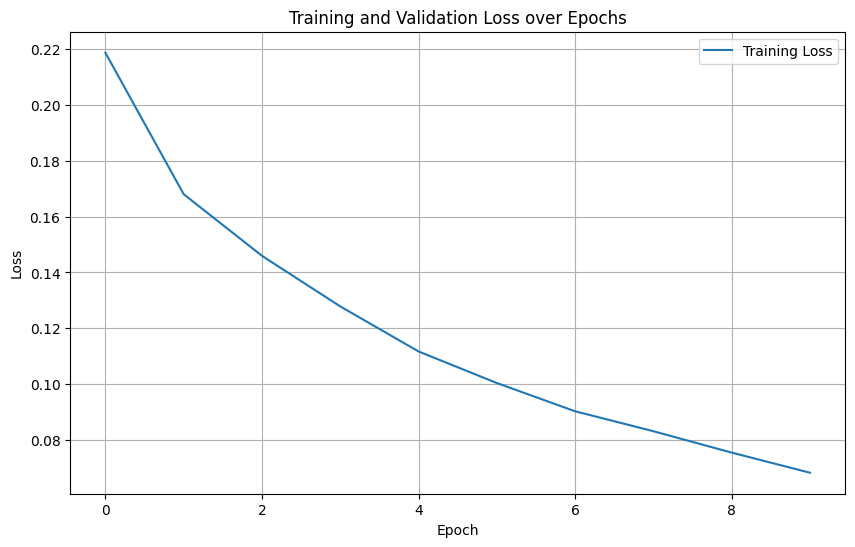

In [ ]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()